# WeRateDogs Twitter Data Analysis

In [1]:
import pandas as pd
import tweepy
import numpy as np
import json
import os
import requests
import pandas.api.types as ptypes
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

## Gather Data

In this section we'll gather the data from multiple sources:
- WeRateDogs Twitter archive
- Tweet images classification (in context of dog breed)
- Retweet and favorite counts from Twitter API

Note that after gathering each data into a dataframe, each dataframe will be copied as "\<dataframe_name\>_unclean" to backup the original uncleaned version of the data. Cleaning operation will not be done to these "unclean" dataframe.

### WeRateDogs Twitter Archive

The data will be loaded from the CSV file `twitter-archive-enhanced.csv`.

In [2]:
twitter_df = pd.read_csv('twitter-archive-enhanced.csv')
twitter_df_unclean = twitter_df.copy() # to backup the raw uncleaned version of the data
twitter_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Tweet Image Predictions

The data will be retrieved from the following URL:  
https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [3]:
if 'image_predictions.tsv' in os.listdir():
    print('"image_predictions.tsv" file already exists, retrieval will be skipped.')
else:
    response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
    with open('image_predictions.tsv', 'wb') as file:
        file.write(response.content)

"image_predictions.tsv" file already exists, retrieval will be skipped.


In [4]:
image_pred_df = pd.read_csv('image_predictions.tsv', sep='\t')
image_pred_df_unclean = image_pred_df.copy() # to backup the raw uncleaned version of the data
image_pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Get Retweet Counts and Like Counts from Tweepy

We'll use Tweepy to get the `retweet_count` and `favorite_count` of every tweet in `twitter_df`. Note that some of the tweets may no longer exists, and for these the `retweet_count` and `favorite_count` will not be available.

In [5]:
if 'tweet_json.txt' in os.listdir():
    print('"tweet_json.txt" file already exists, retrieval will be skipped.')
else:
    tweepy_auth_dir = 'auth/tweepy_auth.json'
    with open(tweepy_auth_dir, 'r') as file:
        tweepy_auth_json = json.load(file)

    key = tweepy_auth_json['key']
    secret = tweepy_auth_json['secret']
    auth = tweepy.OAuthHandler(key, secret)
    api = tweepy.API(auth)
    
    for tweet_id in twitter_df.tweet_id:
        try:
            status = api.get_status(tweet_id, tweet_mode='extended')
            with open('tweet_json.txt', 'a+') as out_file:
                json.dump(status._json, out_file)
                out_file.write('\n')
        except:
            pass

"tweet_json.txt" file already exists, retrieval will be skipped.


In [6]:
tweet_infos = []
with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet_json = json.loads(line)
        tweet_infos.append({'tweet_id': tweet_json['id_str'],
                           'retweet_count': tweet_json['retweet_count'],
                           'favorite_count': tweet_json['favorite_count']})
tweet_infos_df = pd.DataFrame(tweet_infos)
tweet_infos_df_unclean = tweet_infos_df.copy() # to backup the raw uncleaned version of the data
tweet_infos_df.to_csv('tweet_infos.csv', index=False)
tweet_infos_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7417,35140
1,892177421306343426,5517,30411
2,891815181378084864,3640,22869
3,891689557279858688,7584,38400
4,891327558926688256,8166,36651


## Data Assessment and Cleaning
First and foremost, we'd like to remove all statuses that are retweets/replies, so that they don't hamper the analysis result. This will be done in 2 steps, i.e. to first create the is_retweet and is_reply columns, then dropping all rows that are retweets/replies based on those 2 new columns.

### Convert retweet and reply information columns in `twitter_df` into `is_retweet` and `is_reply`

#### Assessment
The following columns in `twitter_df` are deemed unnecessary for analysis:
- `in_reply_to_status_id`
- `in_reply_to_user_id`
- `retweeted_status_id`
- `retweeted_status_user_id`
- `retweeted_status_timestamp`

Reason is because knowing the exact status ID or User ID that the status is replying to or retweeting from is not useful for the analysis. However, the information that says "this tweet is a reply" or "this tweet is a retweet" will be useful and can be obtained from these columns, so we'll create those columns instead.

Below we'll show how many of the not null values of these columns.

In [7]:
twitter_df.in_reply_to_status_id.notna().sum()

78

In [8]:
twitter_df.retweeted_status_id.notna().sum()

181

As can be seen above, there are 78 replies and 181 retweets statuses. Below we'll first convert them into `is_reply` and `is_retweet`.

#### Cleaning
Create new columns `is_reply` and `is_retweet`, where the value is `True` if the value of `in_reply_to_status_id` and `retweeted_status_id` is non-null respectively.

In [9]:
twitter_df['is_reply'] = twitter_df.in_reply_to_status_id.notna()
twitter_df['is_retweet'] = twitter_df.retweeted_status_id.notna()

# test
assert twitter_df.is_reply.sum() == twitter_df.in_reply_to_status_id.notna().sum()
assert twitter_df.is_retweet.sum() == twitter_df.retweeted_status_id.notna().sum()

Drop the columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` from `twitter_df`.

In [10]:
cols_to_drop = ['in_reply_to_status_id',
                'in_reply_to_user_id',
                'retweeted_status_id',
                'retweeted_status_user_id',
                'retweeted_status_timestamp']
twitter_df.drop(columns=cols_to_drop, inplace=True)

# test
assert not twitter_df.columns.isin(cols_to_drop).any()

#### Reassessment
Below shows that now the `twitter_df` is more concise.

In [11]:
twitter_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,is_reply,is_retweet
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,False,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,False,False
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,False,False
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,False,False
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,False,False


In [12]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
 12  is_reply            2356 non-null   bool  
 13  is_retweet          2356 non-null   bool  
dtypes: bool(2), int64(3), object(9)
memory usage: 225.6+ KB


### Remove all rows that are retweets or reply

#### Assessment
Some of the tweets are actually just retweets or replies, which may hamper analysis result. So from this we'll decide to remove those rows. Below shows number of rows that are either retweet or reply.

In [13]:
n = (twitter_df.is_retweet | twitter_df.is_reply).sum()
p = n / twitter_df.shape[0]
print(f'Number of retweets or replies are {n}, which is {p*100:.0f}% of the whole twitter_df.')

Number of retweets or replies are 259, which is 11% of the whole twitter_df.


#### Cleaning

In [14]:
twitter_df = twitter_df[(~twitter_df.is_retweet) & (~twitter_df.is_reply)]

In [15]:
# test
assert twitter_df.is_retweet.sum() == 0
assert twitter_df.is_reply.sum() == 0

#### Reassessment
Below we'll ensure that there is no more tweets that are retweet / reply.

In [16]:
print(f'Number of retweets: {twitter_df.is_retweet.sum()}')

Number of retweets: 0


In [17]:
twitter_df.is_retweet.unique()

array([False])

In [18]:
print(f'Number of replies: {twitter_df.is_reply.sum()}')

Number of replies: 0


In [19]:
twitter_df.is_reply.unique()

array([False])

### Data Completeness - `twitter_df`

#### Assessment

In [20]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
 12  is_reply            2097 non-null   bool  
 13  is_retweet          2097 non-null   bool  
dtypes: bool(2), int64(3), object(9)
memory usage: 217.1+ KB


As you can see above, the following columns have null values: 
- `in_reply_to_status_id`
- `in_reply_to_user_id`
- `retweeted_status_id`
- `retweeted_status_user_id`
- `retweeted_status_timestamp`
- `expanded_urls`

For the `in_reply...` and `retweeted_...` columns, they make sense to have null values, because not all statuses are replying or retweeting another status. As for `expanded_urls`, having null values in them is not an issue, because we most likely won't use this column. So in conclusion, no cleaning action to be done relating to missing data.

### Data Completeness - `tweet_infos_df`

#### Assessment

In [21]:
tweet_infos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2043 non-null   object
 1   retweet_count   2043 non-null   int64 
 2   favorite_count  2043 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 48.0+ KB


No missing value found, hence no cleaning needed.

### Data Completeness - `image_pred_df`
#### Assessment

In [22]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


No missing value found, hence no cleaning needed.

### Column Data Types - `twitter_df`

#### Assessment
Below we'll evaluate the data type of the columns in `twitter_df`.

In [23]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
 12  is_reply            2097 non-null   bool  
 13  is_retweet          2097 non-null   bool  
dtypes: bool(2), int64(3), object(9)
memory usage: 217.1+ KB


Here are the data types issues found from the `info()` above:
- `tweet_id` is of type integer, while it should be string because it's an ID.
- `timestamp` is of type string, while they should be datetime.

#### Cleaning
Below we'll then convert the data types of the columns as described above.

In [24]:
twitter_df.tweet_id = twitter_df.tweet_id.astype(str)

# test
assert ptypes.is_string_dtype(twitter_df.tweet_id)

In [25]:
str_to_datetime_cols = ['timestamp']
twitter_df[str_to_datetime_cols] = twitter_df[str_to_datetime_cols].applymap(pd.to_datetime)

# test
for c in str_to_datetime_cols:
    assert ptypes.is_datetime64_any_dtype(twitter_df[c])

#### Reassessment
Below we'll reassess the new data types of the columns mentioned above, and evaluate their new values.

In [26]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
 12  is_reply            2097 non-null 

In [27]:
twitter_df.tweet_id.sample(5)

1569    687807801670897665
98      873213775632977920
1577    687399393394311168
547     805520635690676224
507     812709060537683968
Name: tweet_id, dtype: object

In [28]:
twitter_df.timestamp[twitter_df.timestamp.notna()].sample(5)

1162   2016-04-23 01:41:59+00:00
1131   2016-05-07 16:34:32+00:00
1313   2016-03-07 18:09:06+00:00
2146   2015-11-26 16:59:01+00:00
951    2016-07-10 01:23:49+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

By looking at the assessments above, we can confirm that now the data types are correct and the values seems reasonable.

You may notice that some of the IDs may have shorter length. This is normal, because based on [this documentation from Twitter](https://developer.twitter.com/en/docs/twitter-ids#:~:text=Today%2C%20Twitter%20IDs%20are%20unique,number%2C%20and%20a%20sequence%20number.), they represent ID as 64 bits integer number (but recommended to be stored as string to avoid losing accuracy in systems with lower bits integer representations). Hence, it is expected for the ID to have different lengths. No zero padding is required.

There will be another data type conversion for the dog stage columns `doggo`, `floofer`, `pupper`, and `puppo` in latter section as well, where we'll convert the columns into boolean type.

### Column Data Types - `tweet_infos_df`

#### Assessment

In [29]:
tweet_infos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2043 non-null   object
 1   retweet_count   2043 non-null   int64 
 2   favorite_count  2043 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 48.0+ KB


The data type of the columns above seems to be correct, hence no cleaning needed.

### Column Data Types - `image_pred_df`

#### Assessment

In [30]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Data type issues found:
- `tweet_id` is integer, while it should be string since it is an ID.

#### Cleaning
Below we'll convert the `tweet_id` column to be string.

In [31]:
image_pred_df.tweet_id = image_pred_df.tweet_id.astype(str)

# test
assert ptypes.is_string_dtype(image_pred_df.tweet_id)

#### Reassessment

In [32]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [33]:
image_pred_df.tweet_id.sample(5)

1777    828381636999917570
684     683852578183077888
1289    751251247299190784
367     672964561327235073
141     668567822092664832
Name: tweet_id, dtype: object

The above assessments show that the data type has been converted correctly.

### Data Tidiness - `tweet_infos_df` separated from `twitter_df`

#### Assessment
An obvious data tidiness issue is the `tweet_infos_df` being separated from the `twitter_df`. Both of them should be combined together, because the columns `retweet_count` and `favorite_count` should belong to `twitter_df`.

#### Cleaning
Below we'll merge the `tweet_infos_df` into `twitter_df`.

In [34]:
original_shape = twitter_df.shape # for testing

# clean
twitter_df = twitter_df.merge(tweet_infos_df, left_on='tweet_id', right_on='tweet_id', how='left')

# test
assert {'retweet_count', 'favorite_count'}.issubset(twitter_df.columns)
assert twitter_df.shape == (original_shape[0], original_shape[1]+2)

#### Reassessment

In [35]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
 12  is_reply            2097 non-null 

In [36]:
twitter_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,is_reply,is_retweet,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,False,False,7417.0,35140.0
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,False,False,5517.0,30411.0
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,False,False,3640.0,22869.0
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,False,False,7584.0,38400.0
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,False,False,8166.0,36651.0


The above assessment confirms that the merge is successful. Note that you may notice the data type of `retweet_count` and `favorite_count` is converted to float after the merge operation. This is a well-known problem in pandas library, and it is because the column contains NaN values. NaN values cannot be represented by integer, thus this is the reason the data type is converted to float after the merge operation. This is not an issue as the float type still allows numeric operation on those columns, while allowing NaN values in those columns as well. Hence, no cleaning needs to be done for this.

### Data Quality - Dog Stage Columns "None" String Values
#### Assessment
Let's now assess the `doggo`, `floofer`, `pupper`, and `puppo` columns in `twitter_df`, which represent the various dog "stages".

In [37]:
print(twitter_df.doggo.unique())
print(twitter_df.floofer.unique())
print(twitter_df.pupper.unique())
print(twitter_df.puppo.unique())

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


As you can see, there are string "None" values in those columns, which are invalid and misleading. This can make it hard for programmatic analysis later on.

#### Cleaning
We'll replace the string "None" values to be actual `NaN` values to ease the analysis.

In [38]:
dog_stages_cols = ['doggo', 'floofer', 'pupper', 'puppo']
twitter_df[dog_stages_cols] = twitter_df[dog_stages_cols].replace('None', np.nan)

# test - ensure that there is no more 'None' string values
assert (twitter_df[dog_stages_cols] == 'None').sum().sum() == 0

#### Reassessment

It is confirmed below that the "None" string values have been replaced with `NaN` values, shown by the `nan` in the list of unique values.

In [39]:
print(twitter_df.doggo.unique())
print(twitter_df.floofer.unique())
print(twitter_df.pupper.unique())
print(twitter_df.puppo.unique())

[nan 'doggo']
[nan 'floofer']
[nan 'pupper']
[nan 'puppo']


Below we'll reassess the actual number of null values for these dog stages columns.

In [40]:
twitter_df[['doggo', 'floofer', 'pupper', 'puppo']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   doggo    83 non-null     object
 1   floofer  10 non-null     object
 2   pupper   230 non-null    object
 3   puppo    24 non-null     object
dtypes: object(4)
memory usage: 81.9+ KB


As you can see now apparently there are a lot of null values for the dog stages columns. However, as we'll see in the next section, these columns actually only represents the existence of those dog stages word in the tweet status. This means it makes sense to have a lot of null values, because not all tweets will mention those dog stages words. Hence no cleaning action will be done regarding these missing dog stages column values.

### Column Data Type - Dog Stages Columns in `twitter_df`

#### Assessment
As described in previous section, apparently the dog stages columns in `twitter_df` actually represents existence of the dog stage word in the tweet status. This column currently is weirdly represented using string, and the representation of the values are also weird. For example, existence of "doggo" word in the tweet status is represented by the column `doggo` having string value of "doggo", which is very redundant. I would expect their data types to be boolean instead, with value `True` if the corresponding dog stage appears in the tweet status.

#### Cleaning
Convert the data type and values of `doggo`, `floofer`, `pupper`, `puppo` in `twitter_df` into boolean. For the values, give value `True` if the value is non-null, and `False` if the value is null. This is safe to be done since in the above section, we've checked the unique values of each dog stage column to only contain either NaN or the dog stage name itself. There won't be any case where a dog stage column contains string value that represents the other dog stage name. For clarity, below we'll reproduce the unique values again.

In [41]:
dog_stages_cols = ['doggo', 'floofer', 'pupper', 'puppo']
for c in dog_stages_cols:
    print(f'{c} unique values: {twitter_df[c].unique()}')

doggo unique values: [nan 'doggo']
floofer unique values: [nan 'floofer']
pupper unique values: [nan 'pupper']
puppo unique values: [nan 'puppo']


Below then we'll do the conversion to boolean.

In [42]:
twitter_df[dog_stages_cols] = twitter_df[dog_stages_cols].applymap(lambda x: False if pd.isna(x) else True)

# test
for c in dog_stages_cols:
    assert ptypes.is_bool_dtype(twitter_df[c])
assert twitter_df.doggo.sum() == 83
assert twitter_df.floofer.sum() == 10
assert twitter_df.pupper.sum() == 230
assert twitter_df.puppo.sum() == 24

#### Reassessment
Below we'll check the data type of the dog stages columns.

In [43]:
twitter_df[dog_stages_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   doggo    2097 non-null   bool 
 1   floofer  2097 non-null   bool 
 2   pupper   2097 non-null   bool 
 3   puppo    2097 non-null   bool 
dtypes: bool(4)
memory usage: 24.6 KB


We'll also check the number of True values in those columns, which we expect to be the same as the previous non-null values count of those columns (because after our transformation, null should equal False and non-null should equal True).

In [44]:
twitter_df[dog_stages_cols].sum()

doggo       83
floofer     10
pupper     230
puppo       24
dtype: int64

As can be seen, the number of True values matches the number of non-null values of the columns before the transformation (refer to the values presented in previous section).

### Data Accuracy - Multiple Dog Stages in a Row (while actually there is only one dog)

#### Assessment
Next, let's see whether is it possible for a row to have multiple dog stages.

In [45]:
dog_stages_count = twitter_df[['doggo', 'floofer', 'pupper', 'puppo']].sum(axis=1)
print(f'Possible number of dog stages in a row: {dog_stages_count.unique()}')

Possible number of dog stages in a row: [0 1 2]


There are indeed suprisingly some rows that have 2 dog stages. Since this dog stage information is derived from the corresponding tweet status text, let's now see the corresponding statuses of these rows.

In [46]:
multi_dog_stages_rows = twitter_df[dog_stages_count >= 2]
statuses = multi_dog_stages_rows.text.values
for s in statuses:
    print('- ' + s)

- Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
- At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
- This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
- Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
- This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
- This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd
- Pupper butt 1, Doggo 0. Both 12/10 https:/

Evaluating the list of twitter statuses above (and also actually opening the pictures of the tweets), most of them have multiple dog stages because the status and the picture itself are involving more than one dogs, which totally makes sense. However, some rows actually only have one dog, but the tweet status mentions multiple dog stages in the text. For these cases, the multiple dog stages will indeed be misleading. Since the number is not much, we will fix them one by one.

#### Cleaning
From visual observation of the above statuses, below we lists down the statuses that actually only have one dog (with misleadingly multiple dog stages in the text).

In [47]:
idxs_invalid_multi_dog_stages = multi_dog_stages_rows.index[[0, 1, 2, 5, 8]]
for s in twitter_df.iloc[idxs_invalid_multi_dog_stages].text.values:
    print('- ' + s)

- Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
- At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
- This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
- This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd
- Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8


Below I list down one by one the correct stage for each tweet status, derived from each of the text above, and then immediately do the correction to the dog stage columns values.

In [48]:
correct_stages = ['puppo', 'floofer', 'pupper', 'pupper', 'doggo']
dog_stages_columns = np.array(['doggo', 'floofer', 'pupper', 'puppo'])

for row, col in zip(idxs_invalid_multi_dog_stages, correct_stages):
    cols_to_false = dog_stages_columns[dog_stages_columns != col]
    twitter_df.loc[row, cols_to_false] = False

# test
assert (twitter_df.loc[idxs_invalid_multi_dog_stages, dog_stages_columns].sum(axis=1).unique() == 1).all()

#### Reassessment
Below we'll check again whether the rows with invalid-multi-dog-stages are now having only one dog stage per row.

In [49]:
pd.options.display.max_colwidth = 150 # so we can see the whole status text
twitter_df.loc[idxs_invalid_multi_dog_stages, np.append('text', dog_stages_columns)]

,text,doggo,floofer,pupper,puppo
154,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.c...,False,False,False,True
161,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https...",False,True,False,False
358,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https...",False,False,True,False
536,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https...,False,False,True,False
748,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,True,False,False,False


In [50]:
pd.options.display.max_colwidth = 50 # reset display

The above prints shows that those rows no longer have invalid multiple dog stages.

### Data Tidiness - Change Index of `twitter_df` and `image_pred_df` to `tweet_id`

#### Assessment
As seen below, the number of unique values for the `tweet_id` are the same as the total number of rows for both `twitter_df` and `image_pred_df`. This means we can set their indexes to be `tweet_id`, which makes more sense and will ease analysis.

In [51]:
print(f'Number of unique ID ({len(twitter_df.tweet_id.unique())}) '
      + f'is same as the number of rows of twitter_df ({twitter_df.shape[0]}).')

Number of unique ID (2097) is same as the number of rows of twitter_df (2097).


In [52]:
print(f'Number of unique ID ({len(image_pred_df.tweet_id.unique())}) '
      + f'is same as the number of rows of twitter_df ({image_pred_df.shape[0]}).')

Number of unique ID (2075) is same as the number of rows of twitter_df (2075).


#### Cleaning
Below we'll convert the indexes of `twitter_df` and `imaged_pred_df` into `tweet_id`.

In [53]:
twitter_df.set_index('tweet_id', inplace=True)
image_pred_df.set_index('tweet_id', inplace=True)

# test
assert twitter_df.index.name == 'tweet_id'
assert image_pred_df.index.name == 'tweet_id'

#### Reassessment
Below we'll see that now their indexes are set to be `tweet_id`.

In [54]:
twitter_df.head(2)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,is_reply,is_retweet,retweet_count,favorite_count
tweet_id,,,,,,,,,,,,,,,
892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,False,False,False,False,False,False,7417.0,35140.0
892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,False,False,False,False,False,False,5517.0,30411.0


In [55]:
image_pred_df.head(2)

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


### Data Accuracy - `rating_numerator` and `rating_denominator` in `twitter_df`

#### Assessment
Let's assess the `describe()` below.

In [56]:
twitter_df.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2097.000000,2097.000000,1815.000000,1815.000000
mean,12.189318,10.448736,2570.371901,8731.992837
std,40.364996,6.645061,4445.389606,12365.106995
min,0.000000,2.000000,11.000000,69.000000
25%,10.000000,10.000000,529.500000,1569.500000
50%,11.000000,10.000000,1316.000000,4333.000000
75%,12.000000,10.000000,2962.500000,11201.000000
max,1776.000000,170.000000,74834.000000,151127.000000


It is weird to see that the `rating_numerator` hs minimum value of 0 and maximum value of 1776. Same goes for `rating_denominator`, with minimum value of 0 and maximum value of 170. The reason this is weird for me is because it is described by the [WeRateDogs wikipedia page](https://en.wikipedia.org/wiki/WeRateDogs) that the rating numerator is in general higher than 10, and the denominator is mostly 10. Below we'll investigate further for the rows that have these weird numerator and denominator values.

In [57]:
pd.options.display.max_colwidth = 150 # so we can see the whole status text
idxs = twitter_df.rating_numerator <= 10
twitter_df.loc[idxs, ['text', 'rating_numerator', 'rating_denominator']].head()

,text,rating_numerator,rating_denominator
tweet_id,,,
883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
848212111729840128,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https:/...",6,10
847962785489326080,This is Georgie. He's very shy. Only puppears when called. Aggressively average at fetch. Unique front paws. Looks slippery. 10/10 would pet https...,10,10
840696689258311684,I didn't even have to intervene. Took him 4 minutes to realize his error. 10/10 for Kevin https://t.co/2gclc1MNr7,10,10
835152434251116546,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10


As you can see above, one of the rows for ID "883482846933004288" has rating that is actually decimal 13.5/10. However, the numerator is detected as 5. It seems that the original rating detection didn't take into account possibility of the rating having decimal point.

#### Cleaning
Hence below I will re-extract the rating from the text, taking into account both the possibilities of:
- the rating having decimal points
- having multiple ratings within a single tweet

I will now store the rating in a separate dataframe than `twitter_df`. This is also because there can be multiple ratings per tweet, hence this will need a separate dataframe to be able to store the data correctly. The new dataframe name will be `dog_ratings_df`. We'll rename the resulting `match` index in to be `rating_no` to represent the index of multiple ratings within a single tweet status.

In [58]:
dog_ratings_df = twitter_df.text.str.extractall('(((\d+\.)?\d+)/((\d+\.)?\d+))')[[1,3]]
dog_ratings_df.columns = ['numerator', 'denominator']
dog_ratings_df.index.rename(['tweet_id', 'rating_no'], inplace=True)

# test
assert dog_ratings_df.index.names[0] == 'tweet_id'
assert dog_ratings_df.index.names[1] == 'rating_no'
assert dog_ratings_df.columns[0] == 'numerator'
assert dog_ratings_df.columns[1] == 'denominator'

#### Reassessment
Here we check whether the detection of rating with decimal point is successful.

In [59]:
idx_with_dec = dog_ratings_df.numerator.str.contains('\.')
ratings_with_dec = dog_ratings_df[idx_with_dec]
ids_with_dec = ratings_with_dec.index.get_level_values('tweet_id')
ratings_with_dec.join(twitter_df.loc[ids_with_dec].text) # to show together with the tweet status text

,,numerator,denominator,text
tweet_id,rating_no,,,
883482846933004288,0,13.5,10,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948"
786709082849828864,0,9.75,10,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"
778027034220126208,0,11.27,10,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...
680494726643068929,0,11.26,10,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


You can see that the detection of rating seems to be effective for decimal numerator values. Since we've ensured that decimal detection was successful, we can now convert the data type of the rating values to float.

#### Cleaning
Below we'll then convert the data type of the ratings numerator and denominator to float.

In [60]:
dog_ratings_df = dog_ratings_df.astype(float)
dog_ratings_df.head()

,,numerator,denominator
tweet_id,rating_no,,
892420643555336193,0,13.0,10.0
892177421306343426,0,13.0,10.0
891815181378084864,0,12.0,10.0
891689557279858688,0,13.0,10.0
891327558926688256,0,12.0,10.0


In [61]:
dog_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2125 entries, ('892420643555336193', 0) to ('666020888022790149', 0)
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   numerator    2125 non-null   float64
 1   denominator  2125 non-null   float64
dtypes: float64(2)
memory usage: 136.0+ KB


#### Reassessment
Now we'll evaluate the detected denominator values first. At least the denominator values expectation is clearer, where we'd like for the denominator to be exactly 10. Any deviation from that should be investigated further. Below we'll then show the tweets that have denominator being not equal to 10, with their corresponding tweet status.

In [62]:
dog_ratings_df[dog_ratings_df.denominator != 10].join(twitter_df.text)

,,numerator,denominator,text
tweet_id,rating_no,,,
820690176645140481,0,84.0,70.0,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
810984652412424192,0,24.0,7.0,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...
758467244762497024,0,165.0,150.0,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
740373189193256964,0,9.0,11.0,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
731156023742988288,0,204.0,170.0,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
722974582966214656,0,4.0,20.0,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
716439118184652801,0,50.0,50.0,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
713900603437621249,0,99.0,90.0,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
710658690886586372,0,80.0,80.0,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12


As can be seen above, some of them are mistakenly extracted from common phrases such as "7/11" and "24/7", while the others are actually valid rating. However, since this will affect the fairness of rating comparison, we'll simply drop all ratings whose denominator is not 10.

#### Cleaning
Drop all the ratings whose denominator is not 10.

In [63]:
dog_ratings_df = dog_ratings_df[dog_ratings_df.denominator == 10]

# test
assert (dog_ratings_df.denominator != 10).sum() == 0

#### Reassessment
From the print of unique values below, now we're sure that the denominator are all 10.

In [64]:
dog_ratings_df.denominator.unique()

array([10.])

Next, we'll evaluate the numerator values. We'll display the unique values of the numerator, sorted from lowest to highest.

In [65]:
unique_nums = dog_ratings_df.numerator.unique()
unique_nums.sort()
unique_nums.astype(str)

array(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0',
       '9.0', '9.75', '10.0', '11.0', '11.26', '11.27', '12.0', '13.0',
       '13.5', '14.0', '420.0', '1776.0'], dtype='<U32')

There seems to be some oddly high numerator values as seen above, i.e. for the values greater than 17. Also there are values that are lower than 10, which is unusual since the site says the numerator should be >= 10.

For now, let's evaluate the tweets that has rating numerator > 17.

In [66]:
ratings_num_big = dog_ratings_df[dog_ratings_df.numerator > 17]
ratings_num_big.join(twitter_df.text)

,,numerator,denominator,text
tweet_id,rating_no,,,
749981277374128128,0,1776.0,10.0,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
670842764863651840,0,420.0,10.0,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY


Again for fair comparison in the rating, we'll remove any numerator ratings that are greater than 17.

#### Cleaning
Remove any numerator ratings that are greater than 17 in the ratings dataframe.

In [67]:
dog_ratings_df = dog_ratings_df[dog_ratings_df.numerator <= 17]

# test
assert (dog_ratings_df.numerator > 17).sum() == 0

#### Reassessment
Below description will show that now the rating numerators have sensible values between 10 to 17.

In [68]:
dog_ratings_df.numerator.describe()

count    2106.000000
mean       10.581092
std         2.181806
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: numerator, dtype: float64

Now that the oddly high values of the numerator are settled, we'll now take care of the less than 10 numerator values.

In [69]:
dog_ratings_df.query('numerator <= 10')

,,numerator,denominator
tweet_id,rating_no,,
848212111729840128,0,6.0,10.0
847962785489326080,0,10.0,10.0
840696689258311684,0,10.0,10.0
835152434251116546,0,0.0,10.0
834089966724603904,0,10.0,10.0
...,...,...,...
666049248165822465,0,5.0,10.0
666044226329800704,0,6.0,10.0
666033412701032449,0,9.0,10.0


There appears to be quite a lot, and we assumed that those people that gave numerator <= 10 does not know the rule that the numerator should be greater than 10. In this case then we'll assume that people who gave 0 is equivalent to giving rating of 10. Hence, we'll offset the numerator values by 10 for the rows that have their numerators <= 10.

#### Cleaning
For all the numerator values that are <= 10, increase their value by 10.

In [70]:
dog_ratings_df.loc[(dog_ratings_df.numerator <= 10), 'numerator'] += 10

# test
assert dog_ratings_df.numerator.min() >= 10

#### Reassessment
Below we show that now the numerator ranges from 10 to 20, which are very reasonable values.

In [71]:
dog_ratings_df.numerator.describe()

count    2106.000000
mean       14.716895
std         3.584734
min        10.000000
25%        12.000000
50%        13.000000
75%        19.000000
max        20.000000
Name: numerator, dtype: float64

Now we are settled with `dog_ratings_df`, and the only thing left to do is to drop the rating columns from `twitter_df`.

#### Cleaning
Drop the rating columns `rating_numerator` and `rating_denominator` from `twitter_df`.

In [72]:
twitter_df.drop(columns=['rating_numerator', 'rating_denominator'], inplace=True)

# test
assert not twitter_df.columns.isin(['rating_numerator', 'rating_denominator']).any()

#### Final Reassessment
Below we'll do final reassessment of the final result of this cleaning effort for the dog ratings.

In [73]:
dog_ratings_df.head(2)

,,numerator,denominator
tweet_id,rating_no,,
892420643555336193,0,13.0,10.0
892177421306343426,0,13.0,10.0


In [74]:
dog_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2106 entries, ('892420643555336193', 0) to ('666020888022790149', 0)
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   numerator    2106 non-null   float64
 1   denominator  2106 non-null   float64
dtypes: float64(2)
memory usage: 135.7+ KB


In [75]:
dog_ratings_df.describe()

,numerator,denominator
count,2106.000000,2106.0
mean,14.716895,10.0
std,3.584734,0.0
min,10.000000,10.0
25%,12.000000,10.0
50%,13.000000,10.0
75%,19.000000,10.0
max,20.000000,10.0


The assessments above shows that `dog_ratings_df` looks reasonable.

Below we'll also see that the rating columns are no longer in `twitter_df`.

In [76]:
pd.options.display.max_colwidth = 50 # reset display
twitter_df.head(2)

,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,is_reply,is_retweet,retweet_count,favorite_count
tweet_id,,,,,,,,,,,,,
892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,False,False,False,False,False,False,7417.0,35140.0
892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,False,False,False,False,False,False,5517.0,30411.0


### Data Tidiness - Dog Stage and Dog Name Columns should not be in `twitter_df`

#### Assessment
The dog stage columns `doggo`, `floofer`, `pupper`, and `puppo`, and the `name` column does not seem to belong in the `twitter_df`. They need their own table. We'll separate them into a new dataframe named `tweet_dog_info_df`.

#### Cleaning
Separate the columns `doggo`, `floofer`, `pupper`, `puppo`, and `name` into a new dataframe named `tweet_dog_info_df`.

In [77]:
dog_info_cols = ['name', 'doggo', 'floofer', 'pupper', 'puppo']
tweet_dog_info_df = twitter_df[dog_info_cols].copy()

Drop the columns from `twitter_df`.

In [78]:
twitter_df.drop(columns=dog_info_cols, inplace=True)

# test
assert not twitter_df.columns.isin(dog_info_cols).any()

#### Reassessment
Below we'll evaluate again the resulting dataframes.

In [79]:
tweet_dog_info_df.head(2)

,name,doggo,floofer,pupper,puppo
tweet_id,,,,,
892420643555336193,Phineas,False,False,False,False
892177421306343426,Tilly,False,False,False,False


In [80]:
tweet_dog_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 892420643555336193 to 666020888022790149
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     2097 non-null   object
 1   doggo    2097 non-null   bool  
 2   floofer  2097 non-null   bool  
 3   pupper   2097 non-null   bool  
 4   puppo    2097 non-null   bool  
dtypes: bool(4), object(1)
memory usage: 121.0+ KB


In [81]:
twitter_df.head(2)

,timestamp,source,text,expanded_urls,is_reply,is_retweet,retweet_count,favorite_count
tweet_id,,,,,,,,
892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,False,False,7417.0,35140.0
892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,False,False,5517.0,30411.0


In [82]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 892420643555336193 to 666020888022790149
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   timestamp       2097 non-null   datetime64[ns, UTC]
 1   source          2097 non-null   object             
 2   text            2097 non-null   object             
 3   expanded_urls   2094 non-null   object             
 4   is_reply        2097 non-null   bool               
 5   is_retweet      2097 non-null   bool               
 6   retweet_count   1815 non-null   float64            
 7   favorite_count  1815 non-null   float64            
dtypes: bool(2), datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 198.8+ KB


It is the concluded from assessments above that the structure of `twitter_df` is now tidy as it serves for a single function: to contain technical information for each tweet. `tweet_dog_info_df` then contains dog related information found from the tweet's status.

### Data Validity - Dog Name in `tweet_dog_info_df` Containing Invalid Names
#### Assessment

In [83]:
names = tweet_dog_info_df.name.unique()
names.sort()
names

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

From the above list of names, we can find several invalid names:
- 'None'
- 'a'
- 'actually'
- 'all'
- 'an'
- 'by'
- 'getting'
- 'his'
- 'incredibly'
- 'infuriating'
- 'just'
- 'life'
- 'light'
- 'mad'
- 'my'
- 'not'
- 'officially'
- 'old'
- 'one'
- 'quite'
- 'space'
- 'such'
- 'the'
- 'this'
- 'unacceptable'
- 'very'

Mostly the invalid names are the "None" and all the names that starts with lower case.

#### Cleaning
We'll now change the names that are "None" or starting with lower case to be the actual `None` value.

In [84]:
lower_case_names = tweet_dog_info_df.name.str.contains('^[a-z]')
tweet_dog_info_df.loc[lower_case_names, 'name'] = None

# test
assert tweet_dog_info_df.name.str.contains('^[a-z]').sum() == 0

In [85]:
idxs_none = tweet_dog_info_df.name == 'None'
tweet_dog_info_df.loc[idxs_none, 'name'] = None

# test
assert (tweet_dog_info_df.name == 'None').sum() == 0

#### Reassessment

In [86]:
names = tweet_dog_info_df.name.astype(str).unique()
names.sort()
names

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

As can be seen from the names above that all the invalid names that we observed before are now removed (replaced with `NaN`).

### Dog Breed Values Assessment in `image_pred_df`

#### Assessment
Below we'll assess on the predicted dog breed names in the `image_pred_df`, to see any possible ambiguously similar dog breed names.

In [87]:
dog_breeds = pd.concat((image_pred_df.p1, image_pred_df.p2))
dog_breeds = pd.concat((dog_breeds, image_pred_df.p3))
dog_breeds = dog_breeds.unique()
dog_breeds.sort()
a = dog_breeds[:-1]
b = dog_breeds[1:]
a_lens = np.array([len(x) for x in a])
b_lens = np.array([len(x) for x in b])

In [88]:
# observe only the dog breed names whose length are similar with the previous (this is a sorted list)
len_diffs = np.abs(b_lens - a_lens)
idxs = len_diffs <= 2
idxs = np.insert(idxs, 0, True)
idxs_final = idxs[:-1] | idxs[1:]
idxs_final = np.append(idxs_final, idxs[-1])

In [89]:
dog_breeds[idxs_final]

array(['Afghan_hound', 'African_chameleon', 'African_crocodile',
       'American_alligator', 'American_black_bear', 'Appenzeller',
       'Arabian_camel', 'Bedlington_terrier', 'Bernese_mountain_dog',
       'Border_collie', 'Border_terrier', 'Brabancon_griffon',
       'Brittany_spaniel', 'English_foxhound', 'English_setter',
       'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_horn',
       'French_loaf', 'Gila_monster', 'Gordon_setter', 'Irish_setter',
       'Irish_terrier', 'Irish_wolfhound', 'Italian_greyhound',
       'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever',
       'Lakeland_terrier', 'Lhasa', 'Loafer', 'Pekinese', 'Pembroke',
       'Persian_cat', 'Pomeranian', 'Saluki', 'Samoyed',
       'Scottish_deerhound', 'Sealyham_terrier', 'Shetland_sheepdog',
       'Sussex_spaniel', 'Tibetan_mastiff', 'Tibetan_terrier',
       'Walker_hound', 'Weimaraner', 'acorn_squash', 'affenpinscher',
       'agama', 'alp', 'apron', 'axolotl', 'badger', 'bagel', '

Visually assessing the list of dog breed names above shows that there is no ambiguously similar dog breed name.

### Convert `source` column values in `twitter_df` into categorical values

#### Assessment
Evaluating the unique values of the `source` column in `twitter_df` (shown below), there are only 4 unique values. To be more concise, we can convert this column into a categorical column instead.

In [90]:
twitter_df.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

#### Cleaning
Convert `source` column in `twitter_df` into a categorical column with value: `iphone`, `web_client`, `vine`, and `tweet_deck`.

In [91]:
def conv_to_source_category(x):
    if 'iphone' in x: return 'iphone'
    elif 'Web Client' in x: return 'webclient'
    elif 'vine' in x: return 'vine'
    elif 'tweetdeck' in x: return 'tweetdeck'
    else: return None
twitter_df.source = twitter_df.source.apply(conv_to_source_category).astype('category')

# test
assert ptypes.is_categorical_dtype(twitter_df.source.dtype)
assert twitter_df.source.dtype.categories.isin(['iphone', 'tweetdeck', 'vine', 'webclient']).all()

####  Reassessment
We can see below that now the `source` column is categorical.

In [92]:
twitter_df.source.unique()

['iphone', 'webclient', 'vine', 'tweetdeck']
Categories (4, object): ['iphone', 'webclient', 'vine', 'tweetdeck']

### Dropping completely null values from `tweet_dog_info_df`

#### Assessment
After all the cleaning done, it is found that the `tweet_dog_info_df` contains a lot of "completely null rows". By completely null rows, we mean rows in which all the columns are null. For the dog stages columns `doggo`, `floofer`, `pupper`, and `puppo`, if all of them are `False` and the corresponding `name` column is null, then the row will considered as completely null as well, because this row is practically useless. Below we'll see that there are 678 completely null rows in `tweet_dog_info_df`.

In [93]:
null_rows = tweet_dog_info_df.name.isna() & (tweet_dog_info_df[['doggo', 'floofer', 'pupper', 'puppo']].sum(axis=1) == 0)
tweet_dog_info_df.loc[null_rows]

,name,doggo,floofer,pupper,puppo
tweet_id,,,,,
891087950875897856,None,False,False,False,False
890729181411237888,None,False,False,False,False
887517139158093824,None,False,False,False,False
887343217045368832,None,False,False,False,False
887101392804085760,None,False,False,False,False
...,...,...,...,...,...
666049248165822465,None,False,False,False,False
666044226329800704,None,False,False,False,False
666033412701032449,None,False,False,False,False


#### Cleaning
Drop all the completely null rows from `tweet_dog_info_df`, i.e. rows whose `name` is null and whose dog stages columns are all `False`.

In [94]:
null_rows = tweet_dog_info_df.name.isna() & (tweet_dog_info_df[['doggo', 'floofer', 'pupper', 'puppo']].sum(axis=1) == 0)
tweet_dog_info_df = tweet_dog_info_df.loc[~null_rows].copy()

# test
null_rows_new = tweet_dog_info_df.name.isna() & (tweet_dog_info_df[['doggo', 'floofer', 'pupper', 'puppo']].sum(axis=1) == 0)
assert null_rows_new.sum() == 0

#### Reassessment
Below we'll see that there are no more rows that are completely null in `tweet_dog_info_df`.

In [95]:
print(f'Number of completely null rows in "tweet_dog_info_df": {null_rows_new.sum()}')

Number of completely null rows in "tweet_dog_info_df": 0


### Data Tidiness for `image_pred_df`

#### Assessment
The following columns in `image_pred_df` do not respect the data tidiness rule where each variable should be represented by a single column (they are instead represented by 3 columns):
- p1, p1_conf, p1_dog
- p2, p2_conf, p2_dog
- p3, p3_conf, p3_dog

#### Cleaning
Melt the following columns:
- p1, p1_conf, p1_dog
- p2, p2_conf, p2_dog
- p3, p3_conf, p3_dog

into the following columns:
- pred_level (the value is either 1, 2, or 3)
- pred_confidence
- pred_class
- is_dog

In [96]:
# melt for each variable
id_vars = ['tweet_id', 'jpg_url', 'img_num']
pred_class_df = pd.melt(image_pred_df.reset_index(), id_vars=id_vars, value_vars=['p1', 'p2', 'p3'],
                        var_name='pred_level', value_name='pred_class')
pred_conf_df = pd.melt(image_pred_df.reset_index(), id_vars=id_vars, value_vars=['p1_conf', 'p2_conf', 'p3_conf'],
                        var_name='pred_level', value_name='pred_confidence')
pred_is_dog_df = pd.melt(image_pred_df.reset_index(), id_vars=id_vars, value_vars=['p1_dog', 'p2_dog', 'p3_dog'],
                        var_name='pred_level', value_name='is_dog')

# extract the number for the prediction level
pred_class_df.pred_level = pred_class_df.pred_level.str.extract('(\d+)').astype(int)
pred_conf_df.pred_level = pred_conf_df.pred_level.str.extract('(\d+)').astype(int)
pred_is_dog_df.pred_level = pred_is_dog_df.pred_level.str.extract('(\d+)').astype(int)

# join the dataframes
on_cols = ['tweet_id', 'jpg_url', 'img_num', 'pred_level']
image_pred_df = pred_class_df.merge(pred_conf_df, on=on_cols, how='outer').merge(pred_is_dog_df, on=on_cols, how='outer')

In [97]:
# convert pred_level to be categorical column
levels = image_pred_df.pred_level.unique()
levels.sort()
pred_levels_category = pd.api.types.CategoricalDtype(categories=levels, ordered=True)
image_pred_df.pred_level = image_pred_df.pred_level.astype(pred_levels_category)

In [98]:
# rename columns
image_pred_df.rename(columns={'jpg_url': 'img_url',
                             'img_num': 'img_idx'},
                    inplace=True)

In [99]:
# set index
image_pred_df.set_index(['tweet_id', 'img_idx', 'pred_level'], inplace=True)

In [100]:
image_pred_df.loc[:, :, :]['img_url'].drop_duplicates()

tweet_id            img_idx  pred_level
666020888022790149  1        1             https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
666029285002620928  1        1             https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
666033412701032449  1        1             https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
666044226329800704  1        1             https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
666049248165822465  1        1             https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
                                                                ...                       
891327558926688256  2        1             https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
891689557279858688  1        1             https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
891815181378084864  1        1             https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
892177421306343426  1        1             https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
892420643555336193  1        1             https:/

#### Reassessment
As can be seen below, now the dataframe is tidy in the sense that each variable is only represented by one column.

In [101]:
image_pred_df.head()

,,,img_url,pred_class,pred_confidence,is_dog
tweet_id,img_idx,pred_level,,,,
666020888022790149,1,1,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True
666029285002620928,1,1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True
666033412701032449,1,1,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True
666044226329800704,1,1,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True
666049248165822465,1,1,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True


In [102]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6225 entries, ('666020888022790149', 1, 1) to ('892420643555336193', 1, 3)
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   img_url          6225 non-null   object 
 1   pred_class       6225 non-null   object 
 2   pred_confidence  6225 non-null   float64
 3   is_dog           6225 non-null   bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 273.0+ KB


### Feature Engineering - Audience Score of each Tweet
Before we proceed with analysis, we'll create a new column named `audience_score`. The value will be the sum of `favorite_count` and `retweet_count`. This calculation is based on the assumption that sometimes when people likes a tweet, they will retweet it but forgot to click on the favorite button, so it makes sense to assume that the people who retweets a status also likes the status as well. And if the person even remembers to click on the favorite button before retweeting, means the status was indeed awesome! So adding those as "audience score" makes more sense.

In [103]:
twitter_df['audience_score'] = twitter_df.retweet_count + twitter_df.favorite_count
twitter_df.audience_score.describe()

count      1815.000000
mean      11302.364738
std       16568.270479
min          80.000000
25%        2140.500000
50%        5718.000000
75%       14449.000000
max      225961.000000
Name: audience_score, dtype: float64

In [104]:
twitter_df[['retweet_count', 'favorite_count', 'audience_score']].head()

,retweet_count,favorite_count,audience_score
tweet_id,,,
892420643555336193,7417.0,35140.0,42557.0
892177421306343426,5517.0,30411.0,35928.0
891815181378084864,3640.0,22869.0,26509.0
891689557279858688,7584.0,38400.0,45984.0
891327558926688256,8166.0,36651.0,44817.0


# Conclusion
With the cleaning actions done above, we now come up with the following finalized and cleaned dataframes:
- `twitter_df`: contains tweets technical informations.
- `image_pred_df`: contains dog breed classifications of the image in each tweet.
- `dog_ratings_df`: contains dog ratings found in each tweet. 
- `tweet_dog_info_df`: contains the dog stage and dog name detected in each tweet.

## Dataframes Preview

In [105]:
# set formatting for floating value display
pd.options.display.float_format = '{:.3f}'.format

### `twitter_df`

In [106]:
twitter_df.head()

,timestamp,source,text,expanded_urls,is_reply,is_retweet,retweet_count,favorite_count,audience_score
tweet_id,,,,,,,,,
892420643555336193,2017-08-01 16:23:56+00:00,iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,False,False,7417.000,35140.000,42557.000
892177421306343426,2017-08-01 00:17:27+00:00,iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,False,False,5517.000,30411.000,35928.000
891815181378084864,2017-07-31 00:18:03+00:00,iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,False,False,3640.000,22869.000,26509.000
891689557279858688,2017-07-30 15:58:51+00:00,iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,False,False,7584.000,38400.000,45984.000
891327558926688256,2017-07-29 16:00:24+00:00,iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,False,False,8166.000,36651.000,44817.000


### `image_pred_df`

In [107]:
image_pred_df.head()

,,,img_url,pred_class,pred_confidence,is_dog
tweet_id,img_idx,pred_level,,,,
666020888022790149,1,1,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465,True
666029285002620928,1,1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.507,True
666033412701032449,1,1,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596,True
666044226329800704,1,1,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408,True
666049248165822465,1,1,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560,True


### `dog_ratings_df`

In [108]:
dog_ratings_df.head()

,,numerator,denominator
tweet_id,rating_no,,
892420643555336193,0,13.000,10.000
892177421306343426,0,13.000,10.000
891815181378084864,0,12.000,10.000
891689557279858688,0,13.000,10.000
891327558926688256,0,12.000,10.000


### `tweet_dog_info_df`

In [109]:
tweet_dog_info_df.head()

,name,doggo,floofer,pupper,puppo
tweet_id,,,,,
892420643555336193,Phineas,False,False,False,False
892177421306343426,Tilly,False,False,False,False
891815181378084864,Archie,False,False,False,False
891689557279858688,Darla,False,False,False,False
891327558926688256,Franklin,False,False,False,False


## Columns Preview

### `twitter_df`

In [110]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 892420643555336193 to 666020888022790149
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   timestamp       2097 non-null   datetime64[ns, UTC]
 1   source          2097 non-null   category           
 2   text            2097 non-null   object             
 3   expanded_urls   2094 non-null   object             
 4   is_reply        2097 non-null   bool               
 5   is_retweet      2097 non-null   bool               
 6   retweet_count   1815 non-null   float64            
 7   favorite_count  1815 non-null   float64            
 8   audience_score  1815 non-null   float64            
dtypes: bool(2), category(1), datetime64[ns, UTC](1), float64(3), object(2)
memory usage: 201.0+ KB


### `image_pred_df`

In [111]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6225 entries, ('666020888022790149', 1, 1) to ('892420643555336193', 1, 3)
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   img_url          6225 non-null   object 
 1   pred_class       6225 non-null   object 
 2   pred_confidence  6225 non-null   float64
 3   is_dog           6225 non-null   bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 273.0+ KB


### `dog_ratings_df`

In [112]:
dog_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2106 entries, ('892420643555336193', 0) to ('666020888022790149', 0)
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   numerator    2106 non-null   float64
 1   denominator  2106 non-null   float64
dtypes: float64(2)
memory usage: 135.7+ KB


### `tweet_dog_info_df`

In [113]:
tweet_dog_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1542 entries, 892420643555336193 to 666418789513326592
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     1390 non-null   object
 1   doggo    1542 non-null   bool  
 2   floofer  1542 non-null   bool  
 3   pupper   1542 non-null   bool  
 4   puppo    1542 non-null   bool  
dtypes: bool(4), object(1)
memory usage: 30.1+ KB


## Numeric Columns Statistics

### `twitter_df`

In [114]:
twitter_df.describe()

,retweet_count,favorite_count,audience_score
count,1815.000,1815.000,1815.000
mean,2570.372,8731.993,11302.365
std,4445.390,12365.107,16568.270
min,11.000,69.000,80.000
25%,529.500,1569.500,2140.500
50%,1316.000,4333.000,5718.000
75%,2962.500,11201.000,14449.000
max,74834.000,151127.000,225961.000


### `image_pred_df`

In [115]:
image_pred_df.describe()

,pred_confidence
count,6225.000
mean,0.263
std,0.291
min,0.000
25%,0.051
50%,0.135
75%,0.380
max,1.000


### `dog_ratings_df`

In [116]:
dog_ratings_df.describe()

,numerator,denominator
count,2106.000,2106.000
mean,14.717,10.000
std,3.585,0.000
min,10.000,10.000
25%,12.000,10.000
50%,13.000,10.000
75%,19.000,10.000
max,20.000,10.000


### `tweet_dog_info_df`

In [117]:
tweet_dog_info_df.describe()

,name,doggo,floofer,pupper,puppo
count,1390,1542,1542,1542,1542
unique,929,2,2,2,2
top,Charlie,False,False,False,False
freq,11,1463,1532,1313,1518


## Store the Cleaned Data
Below we'll store each final and cleaned dataframe into CSV format for each.

In [118]:
twitter_df.to_csv('twitter_archive_master.csv')
image_pred_df.to_csv('image_predictions_master.csv')
dog_ratings_df.to_csv('tweet_dog_ratings_master.csv')
tweet_dog_info_df.to_csv('tweet_dog_infos_master.csv')

# Data Analysis
Questions to be answered:
- How does the dog rating relate with the audience score of the tweet?
- What is the most favored dog stage?
- Which one does the public audience favors more, tweets with videos or photos?

## Question: How does the dog rating relate with the audience score of the tweet?

Calculating the correlation between the audience score and "highest dog rating in each tweet" in general below.

In [119]:
numerators = dog_ratings_df.groupby('tweet_id').numerator.max()
aud_score_dog_rating = twitter_df.join(numerators)[['audience_score', 'numerator']].dropna().rename(columns={'numerator': 'numerator_max'})
c = aud_score_dog_rating.corr().loc['audience_score', 'numerator_max']
print(f'Correlation between audience_score and numerator_max is {c:.2f}.')

Correlation between audience_score and numerator_max is -0.25.


Below I'll remove outliers from the data by considering dog rating numerator values with counts < 10 as outliers. This is based on the observation of the counts where some of the outliers have only 2 values.

In [120]:
counts = aud_score_dog_rating.numerator_max.value_counts()
print('Counts of dog rating numerator values:')
print(counts)

Counts of dog rating numerator values:
12.000    439
20.000    369
11.000    353
13.000    291
19.000    116
18.000     88
14.000     50
17.000     39
16.000     29
15.000     24
19.750      1
11.270      1
10.000      1
13.500      1
Name: numerator_max, dtype: int64


Below I'll print the numerator values that are considered as outliers.

In [121]:
non_outlier_idxs = counts[counts>=10].index
aud_score_dog_rating = aud_score_dog_rating.query('numerator_max in @non_outlier_idxs')
print(f'Rating numerator outliers: {counts[~counts.index.isin(non_outlier_idxs)].index.values}')

Rating numerator outliers: [19.75 11.27 10.   13.5 ]


Below I'll plot the mean of audience score VS the dog rating numerator value.

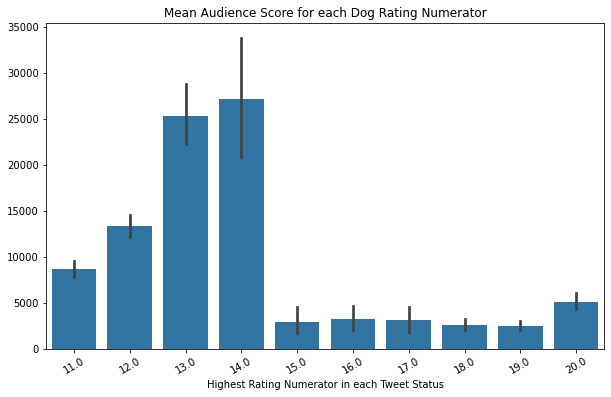

In [122]:
plt.figure(figsize=(10,6))
sb.barplot(data=aud_score_dog_rating, x='numerator_max', y='audience_score', color=sb.color_palette()[0])
plt.xticks(rotation=30);
plt.ylabel('');
plt.xlabel('Highest Rating Numerator in each Tweet Status')
plt.title('Mean Audience Score for each Dog Rating Numerator');

Below I'll calculate the correlation between audience score and the dog rating numerator values for numerator values of 11 up to 14.

In [123]:
# finding correlation for numerator value of 11 to 14
numerators = dog_ratings_df.groupby('tweet_id').numerator.max()
aud_score_dog_rating = twitter_df.join(numerators)[['audience_score', 'numerator']].dropna().rename(columns={'numerator': 'numerator_max'})
aud_score_dog_rating_linear = aud_score_dog_rating.query('numerator_max in @non_outlier_idxs and numerator_max <= 14')

c = aud_score_dog_rating_linear.corr().loc['audience_score', 'numerator_max']
print(f'Correlation between audience_score and numerator_max for numerator_max value of 11.0 to 14.0 is {c:.2f}.')

Correlation between audience_score and numerator_max for numerator_max value of 11.0 to 14.0 is 0.35.


Below I'll re-plot the mean audience score for each dog rating numerator, for numerator values of 11 up to 14.

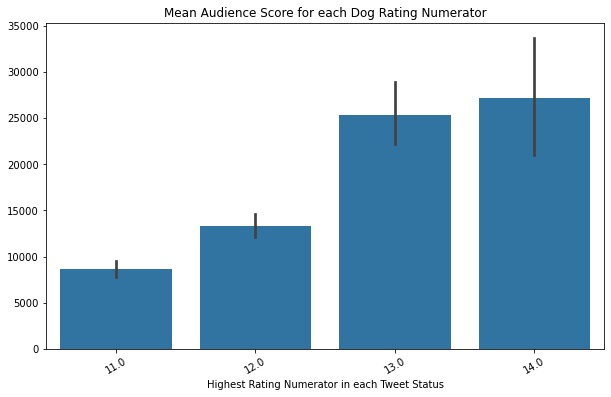

In [124]:
plt.figure(figsize=(10,6))
sb.barplot(data=aud_score_dog_rating_linear, x='numerator_max', y='audience_score', color=sb.color_palette()[0])
plt.xticks(rotation=30);
plt.ylabel('');
plt.xlabel('Highest Rating Numerator in each Tweet Status')
plt.title('Mean Audience Score for each Dog Rating Numerator');

Below I'll calculate the correlation between audience score, retweet count, and favorite count with the dog rating numerator, in general.

In [125]:
numerators = dog_ratings_df.groupby('tweet_id').numerator.max()
aud_score_dog_rating = twitter_df.join(numerators)[['audience_score', 'numerator', 'retweet_count', 'favorite_count']].dropna()
aud_score_dog_rating.corr()

,audience_score,numerator,retweet_count,favorite_count
audience_score,1.000,-0.249,0.960,0.995
numerator,-0.249,1.000,-0.190,-0.266
retweet_count,0.960,-0.190,1.000,0.926
favorite_count,0.995,-0.266,0.926,1.000


Below I'll produce several plots to visualize the distribution of audience score for each dog rating numerator value.

<AxesSubplot:xlabel='numerator', ylabel='audience_score'>

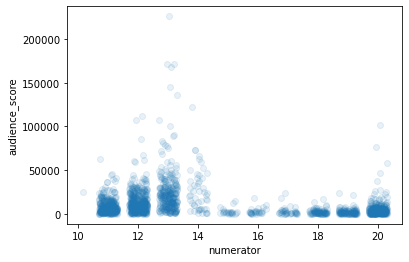

In [126]:
# aud_score_dog_rating.plot(kind='scatter', x='numerator', y='audience_score', alpha=0.2)
sb.regplot(data=aud_score_dog_rating, x=aud_score_dog_rating.numerator.astype(int), y='audience_score', x_jitter=0.3,
          fit_reg=False, scatter_kws={'alpha':0.1})

<AxesSubplot:xlabel='numerator', ylabel='audience_score'>

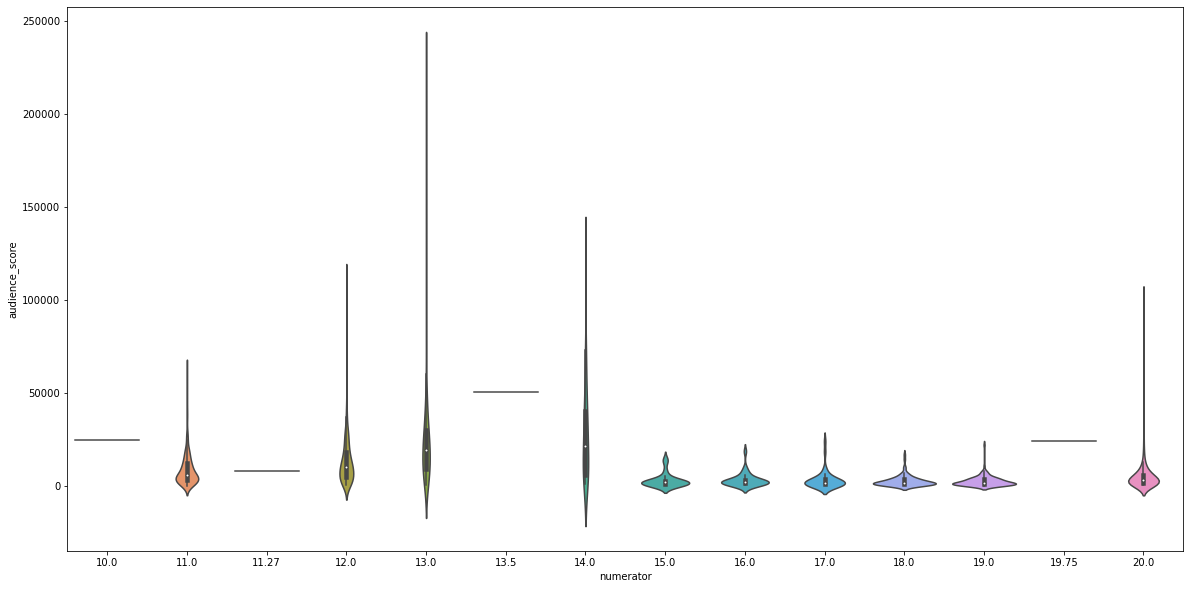

In [127]:
aud_score_dog_rating.numerator = aud_score_dog_rating.numerator.astype('category')
plt.figure(figsize=(20,10))
sb.violinplot(data=aud_score_dog_rating, x='numerator', y='audience_score')

<AxesSubplot:xlabel='numerator', ylabel='audience_score'>

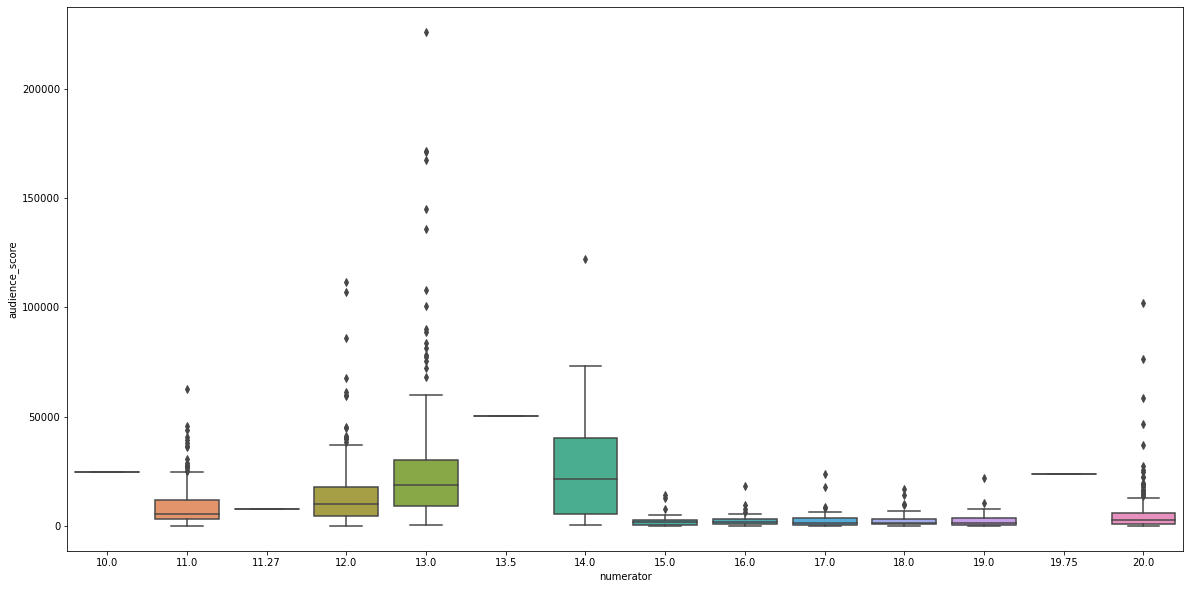

In [128]:
plt.figure(figsize=(20,10))
sb.boxplot(data=aud_score_dog_rating, x='numerator', y='audience_score')

## Question: What is the most favored dog stage?
Answer: In general, floofer is favored by most audience. All those fluffs are really cute indeed!

Below I'll plot the count of each dog stage.

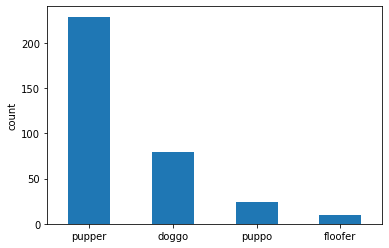

In [129]:
dog_stages_cols = ['doggo', 'floofer', 'pupper', 'puppo']
has_dog_stage = tweet_dog_info_df[dog_stages_cols].sum(axis=1) > 0
dog_stages_info = tweet_dog_info_df.loc[has_dog_stage][dog_stages_cols]
count = dog_stages_info.sum()
count = count.sort_values(ascending=False)
count.plot(kind='bar')
plt.ylabel('count');
plt.xticks(rotation=0);

Below I'll plot the distribution of audience score for each dog stage.

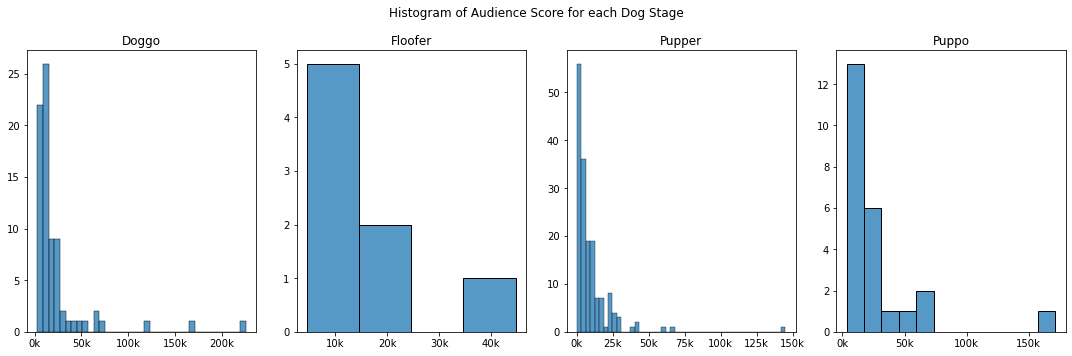

In [130]:
from matplotlib.ticker import FuncFormatter

dog_stage_audience_scores = dog_stages_info.join(twitter_df)

def convert_to_kilo(x, pos):
    return f'{int(x / 1000)}' +'k'

formatter = FuncFormatter(convert_to_kilo)

fig = plt.figure(figsize=(15,5))
fig.suptitle('Histogram of Audience Score for each Dog Stage')
for i, stage in enumerate(dog_stages_cols, start=1):
    plt.subplot(1, 4, i)
    plt.gca().xaxis.set_major_formatter(formatter)
    sb.histplot(dog_stage_audience_scores.query(stage).audience_score)
    plt.title(stage[0].upper() + stage[1:])
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()

**Discussion:**  
Since the distribution is skewed, we'll use median instead of mean to exclude outliers.

Below I'll plot the median audience score for each dog stage.

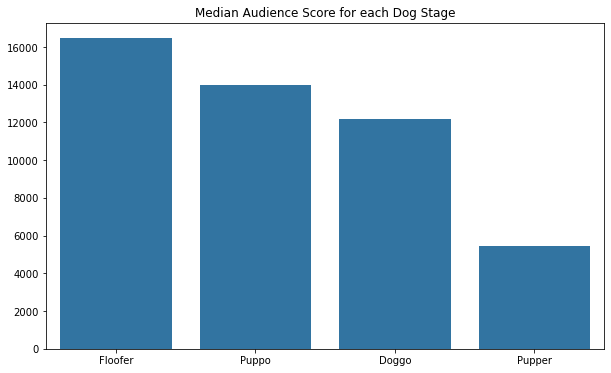

In [131]:
results = []

for stage in dog_stages_cols:
    mean_score = dog_stage_audience_scores.query(stage).audience_score.median()
    results.append({'stage': stage, 'median_audience_score': mean_score})

result_df = pd.DataFrame(results)
result_df= result_df.sort_values('median_audience_score', ascending=False)

plt.figure(figsize=(10,6))
sb.barplot(data=result_df, x='stage', y='median_audience_score', color=sb.color_palette()[0]);
plt.xlabel('')
plt.xticks(ticks=np.arange(4),labels=['Floofer', 'Puppo', 'Doggo', 'Pupper'])
plt.ylabel('')
plt.title('Median Audience Score for each Dog Stage');

## Question: Which one does the public audience favors more, tweets with videos or photos?
Answer: Video has higher audience score in general. Median is again used because of the highly skewed distribution of `audience_score` for each value of `is_video`.

Below I'll create the `is_video` column.

In [132]:
twitter_df['is_video'] = twitter_df.expanded_urls.str.contains('video')
twitter_df.head()

,timestamp,source,text,expanded_urls,is_reply,is_retweet,retweet_count,favorite_count,audience_score,is_video
tweet_id,,,,,,,,,,
892420643555336193,2017-08-01 16:23:56+00:00,iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,False,False,7417.000,35140.000,42557.000,False
892177421306343426,2017-08-01 00:17:27+00:00,iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,False,False,5517.000,30411.000,35928.000,False
891815181378084864,2017-07-31 00:18:03+00:00,iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,False,False,3640.000,22869.000,26509.000,False
891689557279858688,2017-07-30 15:58:51+00:00,iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,False,False,7584.000,38400.000,45984.000,False
891327558926688256,2017-07-29 16:00:24+00:00,iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,False,False,8166.000,36651.000,44817.000,False


Below I'll plot the distribution of audience score for tweets with photo and video.

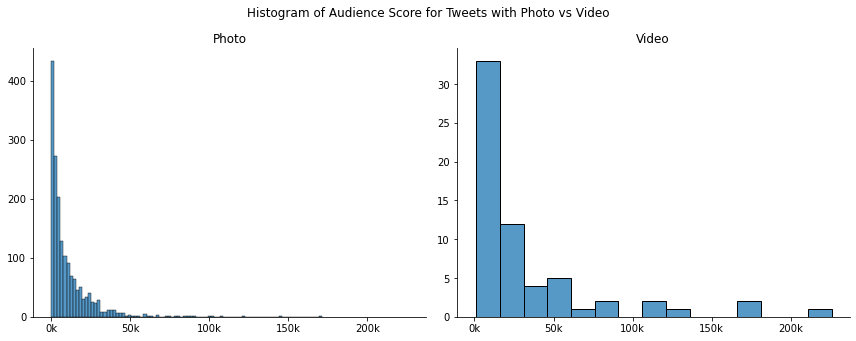

In [133]:
g = sb.FacetGrid(data=twitter_df, col='is_video', sharey=False, height=5, aspect=1.2)
plt.suptitle('Histogram of Audience Score for Tweets with Photo vs Video')
g.map(sb.histplot, 'audience_score', common_norm=False)
axes = g.axes.flatten()
axes[0].set_title('Photo')
axes[1].set_title('Video');
g.set_xlabels('')

for ax in axes:
    ax.xaxis.set_major_formatter(formatter)

**Discussion:**  
Since the distribution is skewed, we'll use median instead of mean to exclude outliers.

Below I'll then plot the median audience score of tweets with photos vs videos.

In [134]:
median_score_is_video = twitter_df.groupby('is_video').audience_score.median()
median_score_is_video

is_video
False    5501.000
True    14995.000
Name: audience_score, dtype: float64

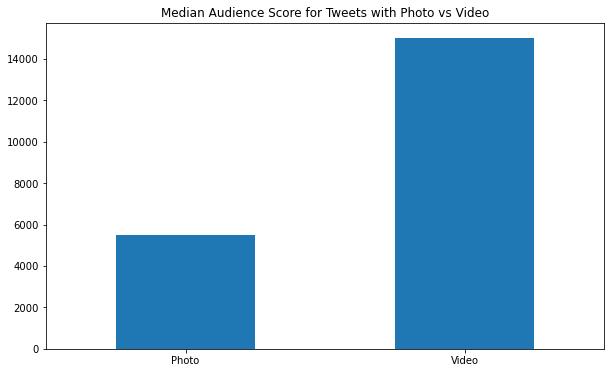

In [135]:
plt.figure(figsize=(10,6))
median_score_is_video.plot(kind='bar')
plt.xticks(rotation=0, ticks=range(2), labels=['Photo', 'Video'])
plt.xlabel('')
plt.title('Median Audience Score for Tweets with Photo vs Video');

# Conclusion
Based on the above analyses, the following conclusions are made:
- In general, dog rating is not a reliable source to predict audience score of the tweet. However, a notable positive linear relationship occurs for dog rating values from 11 to 14, where the audience score increases linearly with the dog rating within this range. Higher than 14, there is no more linear relationship between audience score and dog rating.
- The dog stage that is generally most favored by public audience is Floofer.
- Tweets with videos is generally more favored by public audience than tweets with photos.